In [2]:
import csv
import numpy as np
import keras
import datetime

print("%s start" % datetime.datetime.today())
###
# 1.データ準備
###
print("initializing...")
n = 8500              # 入力層の要素数(=データの最大文字数)
k = 3                 # 出力層の要素数(いくつに分類するか)

max_rows = 50000  # 読み取り行数最大
train_ratio = 0.9 # 読み取ったデータのうち学習に使う比率
print("max_rows=%s" % max_rows)
print("train_ratio=%s" % train_ratio)

print("reading data..")
# numpy.appendは遅いので先にlistに取り込んでからnumpyに展開
xlist=[]
ylist=[]
with open('reviews-ccnn-train-data04.txt', 'r') as f:
    reader = csv.reader(f,delimiter = '\t')
#    header = next(reader)  # ヘッダーを読み飛ばしたい時

    for i,row in enumerate(reader):
        if i >= max_rows:
            break
#        print(i,row[0],row[1])          # 1行づつ取得できる
        if (i+1) % 10000 == 0:
            print("%s %s rows read .. " % (datetime.datetime.today(),i+1))
        x=[]
        for c in row[1]:
            x.append(float(np.int.from_bytes(c.encode('utf-8'),'big')))
        xx = np.array(x)
        xx.resize(n,refcheck=False)
        xx = xx.astype('float32')
        y = float(row[0])
        xlist.append(xx)
        ylist.append(y)

total_rows = len(xlist)
print("%s total %s rows read" % (datetime.datetime.today(),total_rows) )



/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


2018-03-07 03:21:52.895948 start
initializing...
max_rows=50000
train_ratio=0.9
reading data..
2018-03-07 03:21:57.553254 10000 rows read .. 
2018-03-07 03:22:02.092430 20000 rows read .. 
2018-03-07 03:22:06.178677 30000 rows read .. 
2018-03-07 03:22:10.309701 40000 rows read .. 
2018-03-07 03:22:14.317204 50000 rows read .. 
2018-03-07 03:22:14.317879 total 50000 rows read


In [3]:

train_rows = int(total_rows * train_ratio) # 学習に使うデータの行数
test_rows = total_rows - train_rows        # 評価に使うデータの行数
print("%s train_rows=%s" % (datetime.datetime.today(),train_rows))
print("%s test_rows=%s" % (datetime.datetime.today(),test_rows))

X=np.zeros((train_rows,n),float) # 学習用入力データの行列
Y=np.zeros((train_rows,k),float)  # 学習用出力データの行列
X_test=np.zeros((test_rows,n),float) # 評価用入力データの行列
Y_test=np.zeros((test_rows,k),float) # 評価用出力データの行列



2018-03-07 03:24:22.200261 train_rows=45000
2018-03-07 03:24:22.200367 test_rows=5000


In [4]:
train_index = 0
test_index = 0
for i in range(total_rows):
    x = xlist[i]
    y = ylist[i]
#    n_sub_samples = len(x.shape[0]
    # 上位train_rows分を学習データ　それ以外を評価データに使う
    # ホントはシャッフルしたほうがいい
    if i < train_rows:
        X[i:i+1,:] = x
        Y[i:i+1,:] = keras.utils.np_utils.to_categorical(y, k)
    else:
        X_test[i-train_rows:i-train_rows+1,:] = x
        Y_test[i-train_rows:i-train_rows+1,:] = keras.utils.np_utils.to_categorical(y, k)

#X.resize((train_rows,n))
#Y.resize((train_rows,k))
#X_test.resize((test_rows,n))
#Y_test.resize((test_rows,k))

# Xを３次元の行列に変換。この意味はわからない・・Kerasの都合か。
X=X.reshape(X.shape[0],n,1)
X_test=X_test.reshape(X_test.shape[0],n,1)
# 正規化
X /= 0x1FFFFF
X_test /= 0x1FFFFF

print("%s initialized" % datetime.datetime.today())


2018-03-07 03:24:55.534054 initialized


In [5]:
# 学習データの件数確認
X.shape


(45000, 8500, 1)

In [6]:
X_test.shape

(5000, 8500, 1)

In [8]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import Adadelta
#from sklearn import datasets
#from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.layers.core import Dropout
from keras.initializers import TruncatedNormal
from keras.layers import Flatten, Conv1D, MaxPooling1D

###
# 2.モデル設定
###
print("%s building model start" % datetime.datetime.today())
kernel_size = (3)
model = Sequential()
# 入力層
model.add(Conv1D(32, kernel_size=kernel_size,
                 activation='relu',
                 input_shape=(n,1)
                 )
        )
# 畳み込み層
model.add(Conv1D(64, kernel_size, activation='relu'))
# プーリング層
model.add(MaxPooling1D(pool_size=(2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
# 出力層
model.add(Dense(k, activation='softmax'))

# 確率的勾配降下法
model.compile(loss='categorical_crossentropy', optimizer=Adadelta(), metrics=['accuracy'])

print("%s model built" % datetime.datetime.today())


2018-03-07 03:25:50.859390 building model start
2018-03-07 03:25:51.036293 model built


In [9]:
print("%s trainning model start" % datetime.datetime.today())

###
# 3.モデル学習
###
epochs = 50     # 学習繰り返し数
batch_size = 120
hist = model.fit(X, Y, epochs=epochs, batch_size=batch_size,)
#               validation_data=(X_validation ,Y_validation))

print("%s training finish" % datetime.datetime.today())


2018-03-07 03:25:55.542395 trainning model start
Epoch 1/50
45000/45000 [==============================] - 88s 2ms/step - loss: 0.8164 - acc: 0.5230
Epoch 2/50
45000/45000 [==============================] - 82s 2ms/step - loss: 0.7373 - acc: 0.5479
Epoch 3/50
45000/45000 [==============================] - 82s 2ms/step - loss: 0.7251 - acc: 0.5638
Epoch 4/50
45000/45000 [==============================] - 82s 2ms/step - loss: 0.7114 - acc: 0.5807
Epoch 5/50
45000/45000 [==============================] - 82s 2ms/step - loss: 0.6975 - acc: 0.5963
Epoch 6/50
45000/45000 [==============================] - 82s 2ms/step - loss: 0.6815 - acc: 0.6148
Epoch 7/50
45000/45000 [==============================] - 82s 2ms/step - loss: 0.6629 - acc: 0.6335
Epoch 8/50
45000/45000 [==============================] - 82s 2ms/step - loss: 0.6458 - acc: 0.6478
Epoch 9/50
45000/45000 [==============================] - 82s 2ms/step - loss: 0.6292 - acc: 0.6575
Epoch 10/50
45000/45000 [==========================

In [10]:
###
# 4-1.評価
###
print("%s evaluate start" % datetime.datetime.today())
loss_and_metrics = model.evaluate(X_test, Y_test)
print()
print(loss_and_metrics)
# 可視化
val_loss = hist.history['loss']
val_acc = hist.history['acc']
print(val_loss)
print(val_acc)

print("%s evaluate finish" % datetime.datetime.today())


2018-03-07 04:41:07.564364 evaluate start
5000/5000 [==============================] - 2s 447us/step

[1.0103867198944092, 0.5576]
[0.816416476726532, 0.7372776266733805, 0.7251264314651489, 0.7113910072644551, 0.6974862470626831, 0.6815450488726298, 0.6629445869127909, 0.6458388900756836, 0.6291937182744344, 0.6112788797219594, 0.5981222999095916, 0.5810786089897155, 0.568480399131775, 0.555777173837026, 0.5480622871716817, 0.537265211502711, 0.5320164902210236, 0.522331578095754, 0.5207004365921021, 0.5154020001888275, 0.5082264243761698, 0.5111613187789917, 0.5025203053951264, 0.5069513363043467, 0.49853061469395954, 0.4948741005261739, 0.4944120168685913, 0.49790511703491214, 0.494375332514445, 0.4831516714890798, 0.483694270213445, 0.47541127681732176, 0.4786805911858876, 0.4800925208727519, 0.47910313057899473, 0.4742628587881724, 0.4762438784440359, 0.4753591423034668, 0.47290304986635845, 0.47233362730344136, 0.4687194232940674, 0.47089035574595134, 0.46924493853251137, 0.46672

In [11]:
###
# 4-2.予測
###

predicted = model.predict(X_test)


In [12]:
# ランダムに１０個ほど予測結果を確認
for i in np.random.randint(0,max_rows-train_rows,10):
    print(i,Y_test[i],predicted[i])
    # ID化したデータを文字列に戻す
    ss = str()
    for xx in (X_test[i] * 0x1FFFFF).reshape(n).astype(int):
        ixx = int(xx)
        ss += (ixx.to_bytes((ixx.bit_length() + 7) // 8,'big')).decode(encoding='utf-8')

    print(ss)




3975 [0. 1. 0.] [0.00293632 0.7131477  0.28391606]
平日のお昼．駅前らしく活気のある店内．ランチメニューの方がお得だとは思ったが，ちょっと寒い日だったので酸辣湯麺を注文． 　やっちまったかと思った．丼からドロドロと餡がたれまくる．周りの視線が気になるほどの盛り具合．さぁと箸を突っ込むが当然麺には届かない．恐る恐る餡がからむ野菜を口にする．熱い．二口目で汗と鼻水が出始める．せっせと具を食べる．素揚げの鶏肉がうまい．たまらず箸をぐっと突っ込んでレンゲと挟んで麺を引き出す．箸が折れそうだ．麺が絡み合ってどうにもこうにも．中細縮れ麺は既にデロデロ．スープは，ほんのり甘めの醤油味にラー油がピリリときて，生姜がほんのり効く．酸味は感じない．結局，固形物の量はそれほどでもなく，終盤あっさり完食．話のネタになる一杯ではある．
998 [0. 1. 0.] [4.3542218e-13 6.3210875e-02 9.3678916e-01]
宿題の勝浦タンタンメンをソロツーリングで行ってきました。 RDBで勝浦地区１位のこちらに、 1:30少し前に到着。 駐車場が店の横に屋根付きと、 店の前に６台位置けますが、私は屋根付きに！ 邪魔にならないように止めて入店です。  店内はテーブル席しか無く、満席。 ポスターに載ってる店主さんに、 人数を聞かれたので、1人と合図すると、 明らかに嫌な顔をされました(残念) それにもめげずに待つこと10分。 やっと席が空いて案内となり、 表題の物を口頭注文。 直ぐに着丼？ビックリするくらい早いです。  まずはスープから。 醤油ベースの透き通るスープに、 ラー油で炒めた玉ねぎが入りますが、 ほとんど辛さを感じないので、 卓上のラー油で辛味増量！ 出汁は豚骨の様でしっかりコクが有ります。  続いて麺。 加水率低めの中細ストレート麺で、 茹で加減はちょい固めと好みの物。 麺量はそんなに多くないので、 大体150ｇ前後位と思います。 スープのラー油を纏って、啜ると喉越しは良いです。  具材は「ひき肉と玉ねぎのラー油炒め、白髪ネギ」で、 ひき肉は手で細かくしているのか結構大き目。 ラー油も自家製と書いてありましたが、 私としてはもう少し辛くても良いかも。  チャーシューとか入ってないので、CP度は… 結構有名に

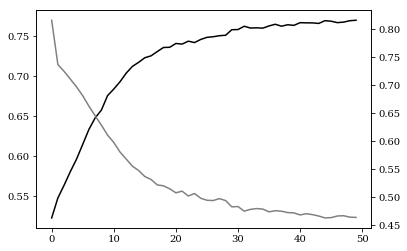

In [13]:
import os

###
# 5.学習の可視化
###

plt.rc('font', family='serif')
fig = plt.figure()
# 精度
ax_acc = fig.add_subplot(111)
ax_acc.plot(range(epochs), val_acc, label='acc', color='black')
# 損失
ax_loss = ax_acc.twinx()
ax_loss.plot(range(epochs), val_loss, label='loss', color='gray')
plt.xlabel('epochs')
#file,ext = os.path.splitext(os.path.basename(__file__))
#plt.savefig(file+'.eps')

plt.show()